# Model Training and Evaluation
This notebook trains and evaluates several baseline classification models on different versions of the training data: the original imbalanced data and data augmented with SMOTE, ADASYN, and Random Oversampling. The goal is to identify the best-performing combination of a model and a data sampling technique based on the F1-score for the positive class (Revenue).

### **Workflow**

1.  **Setup**: Import libraries and load the preprocessed data.
    
2.  **Data Augmentation**: Generate the augmented datasets using SMOTE, ADASYN, and RandomOversampler.
    
3.  **Model Training Loop**:
    
    -   Define a dictionary of models to be tested: Logistic Regression, Decision Tree, Random Forest.
        
    -   Define a dictionary of datasets.
        
    -   Iterate through each model and dataset combination.
        
    -   Train the model, make predictions, and calculate the F1-score.
        
4.  **Results Comparison**:
    
    -   Store the F1-scores in a DataFrame for easy comparison.
        
    -   Visualize the results using a heatmap to quickly identify the best strategy.
        
5.  **Conclusion**: Summarize the findings.

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings


from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import f1_score


warnings.filterwarnings('ignore')

In [2]:
processed_data_path = '../data/processed/'

# Load the datasets
X_train_orig = pd.read_csv(os.path.join(processed_data_path, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(processed_data_path, 'X_test.csv'))
y_train_orig = pd.read_csv(os.path.join(processed_data_path, 'y_train.csv')).values.ravel()
y_test = pd.read_csv(os.path.join(processed_data_path, 'y_test.csv')).values.ravel()

print("Original Data Shapes:")
print(f"X_train: {X_train_orig.shape}, y_train: {y_train_orig.shape}")
print(f"Original y_train distribution:\n{pd.Series(y_train_orig).value_counts(normalize=True)}")

Original Data Shapes:
X_train: (9764, 17), y_train: (9764,)
Original y_train distribution:
0    0.843712
1    0.156288
Name: proportion, dtype: float64


## Generate Augmented Datasets

In [3]:
# SMOTE
smote = SMOTE(random_state=42,sampling_strategy="auto")
X_train_smote, y_train_smote = smote.fit_resample(X_train_orig, y_train_orig)
print(f"\nSMOTE y_train distribution:\n{pd.Series(y_train_smote).value_counts(normalize=True)}")


# ADASYN
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_orig, y_train_orig)
print(f"\nADASYN y_train distribution:\n{pd.Series(y_train_adasyn).value_counts(normalize=True)}")


# Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_orig, y_train_orig)
print(f"\nRandomOversampler y_train distribution:\n{pd.Series(y_train_ros).value_counts(normalize=True)}")


SMOTE y_train distribution:
1    0.5
0    0.5
Name: proportion, dtype: float64

ADASYN y_train distribution:
1    0.502085
0    0.497915
Name: proportion, dtype: float64

RandomOversampler y_train distribution:
1    0.5
0    0.5
Name: proportion, dtype: float64


## Model Training and Evaluation Loop

In [4]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold


# Models and Parameter Grids
param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(random_state=42, max_iter=1000),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "penalty": ["l2"],
            "solver": ["lbfgs", "liblinear"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    }
}


datasets = {
    "Original Imbalanced": (X_train_orig, y_train_orig),
    "SMOTE": (X_train_smote, y_train_smote),
    "ADASYN": (X_train_adasyn, y_train_adasyn),
    "Random Oversampler": (X_train_ros, y_train_ros)
}

# Loop with GridSearchCV
results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for dataset_name, (X_train, y_train) in datasets.items():
    for model_name, cfg in param_grids.items():
        print(f"\n>>> Training {model_name} on {dataset_name} data with GridSearchCV...")

        grid = GridSearchCV(
            estimator=cfg["model"],
            param_grid=cfg["params"],
            scoring="f1",
            cv=cv,
            n_jobs=-1,
            verbose=1
        )

        grid.fit(X_train, y_train)


        best_model = grid.best_estimator_


        y_pred = best_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, pos_label=1)

        results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Best Params": grid.best_params_,
            "CV Best F1": grid.best_score_,
            "Test F1": f1
        })

print("\n--- Cross-Validation and Grid Search Complete ---")


results_df = pd.DataFrame(results)


>>> Training Logistic Regression on Original Imbalanced data with GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

>>> Training Random Forest on Original Imbalanced data with GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

>>> Training Decision Tree on Original Imbalanced data with GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

>>> Training Logistic Regression on SMOTE data with GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

>>> Training Random Forest on SMOTE data with GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

>>> Training Decision Tree on SMOTE data with GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

>>> Training Logistic Regression on ADASYN data with GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

>>> Training Random Forest on ADASYN data with GridSearchCV...
Fitting 

## Results Comparison

In [5]:
results_df

,Dataset,Model,Best Params,CV Best F1,Test F1
0,Original Imbalanced,Logistic Regression,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.498606,0.514886
1,Original Imbalanced,Random Forest,"{'max_depth': None, 'min_samples_split': 5, 'n...",0.651378,0.667630
2,Original Imbalanced,Decision Tree,"{'max_depth': 5, 'min_samples_split': 2}",0.640248,0.666667
3,SMOTE,Logistic Regression,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.826612,0.646396
4,SMOTE,Random Forest,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.930973,0.666667
5,SMOTE,Decision Tree,"{'max_depth': 10, 'min_samples_split': 5}",0.901798,0.600000
6,ADASYN,Logistic Regression,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.809833,0.624481
7,ADASYN,Random Forest,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.932400,0.670468
8,ADASYN,Decision Tree,"{'max_depth': 10, 'min_samples_split': 2}",0.896918,0.599214
9,Random Oversampler,Logistic Regression,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.803264,0.646865


In [15]:
results_df.to_csv('../reports/metrics/results.csv', index=False)

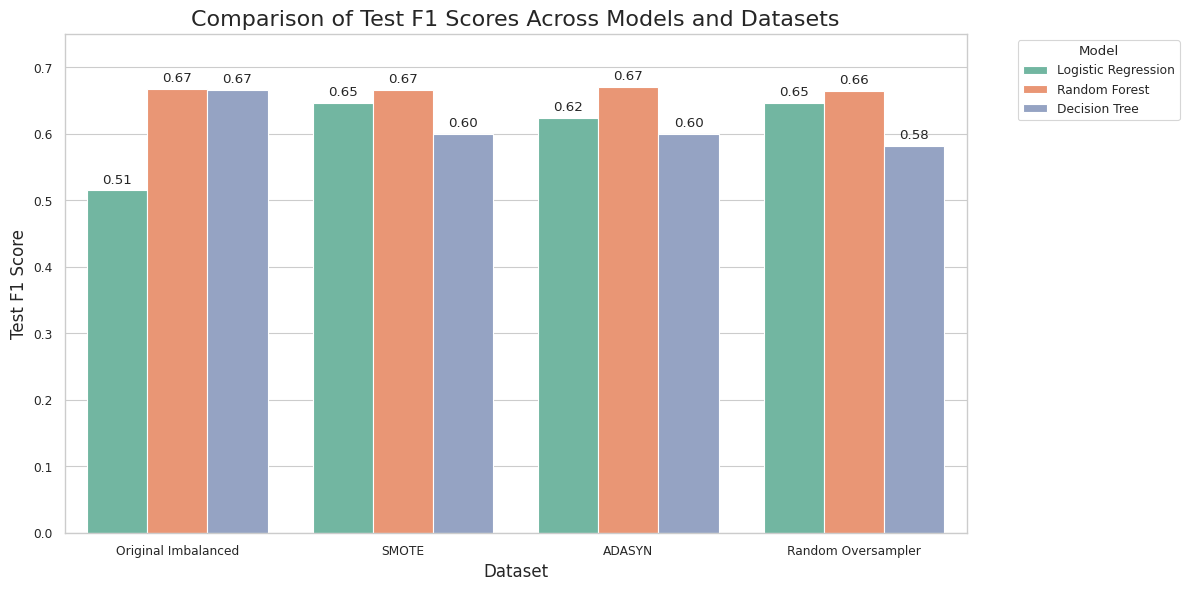

In [14]:
sns.set_context("paper")
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Dataset', y='Test F1', hue='Model', data=results_df, palette='Set2')

plt.title('Comparison of Test F1 Scores Across Models and Datasets', fontsize=16)
plt.ylabel('Test F1 Score', fontsize=12)
plt.xlabel('Dataset', fontsize=12)
plt.ylim(0, 0.75) 

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("../reports/figures/test_f1_scores_comparison.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

### Key insights

-   **Performance summary:** Random Forest achieves the highest and most consistent test F1 scores (~**0.66–0.67**) across all four datasets (Original, SMOTE, ADASYN, Random Oversampler).
    

-   **Logistic Regression behavior:** Logistic Regression  improves substantially with resampling (from **0.51** on imbalanced data to **~0.65** with SMOTE/oversampling), showing that linear models benefit strongly from class balancing but still fall slightly short of Random Forest.
    
-   **Decision Tree issues:** Decision Tree  shows high variance: it matches Random Forest on the original imbalanced set (**0.67**) but drops to **0.58–0.60** after resampling, suggesting overfitting and poor generalization.

> - ✅ **Selected model**: Random Forest classifier, trained on a balanced training set (SMOTE or ADASYN)